### Do the required imports

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt


### Calibrate the camera
Here I collect the image points and the object points from the calibration images. These points are later used for camera calibration.

In [2]:
# number of corners along the x and y axes
nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_size = (gray.shape[1], gray.shape[0])
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)


In the above step I got the image points and object points. Here I pass them to `cv2.calibrateCamera()` to get the distortion matrix `mtx` and the distortion cofficients `dist`. Now I can use `cv2.undistort()` to undistort any image taken from the same camera. 

Note: `mtx` and `dist` are camera specific values and it will be different for every camera.

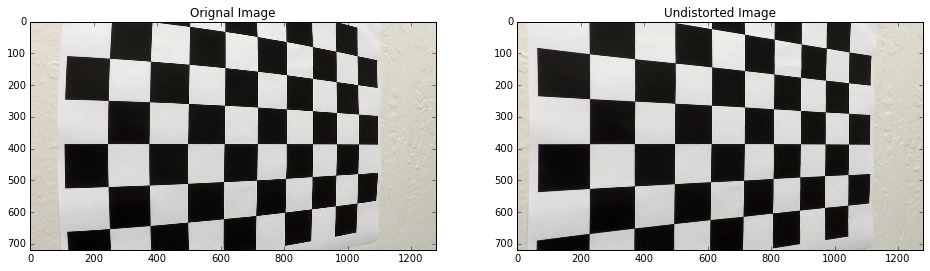

In [3]:
# undistort a test image
img = mpimg.imread('./camera_cal/test.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
u_img = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
ax1.imshow(img)
ax1.set_title('Orignal Image')
ax2.imshow(u_img)
ax2.set_title('Undistorted Image')

At this point I am done with the camera calibration process.


### Building up the pipeline

Here I build and test all the necessary functions that make up my video processing pipeline. 

The first step of the pipeline would be to undistort the input image. For this I define a function `undistort`.

In [4]:
# this function takes an image and returns undistorted image
def undistort(image, mtx, dist):
    return cv2.undistort(image, mtx, dist, None, mtx)

Here I test my `undistort` function over a image.

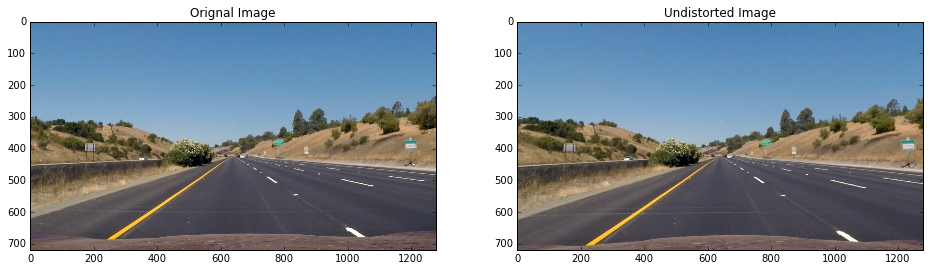

In [5]:
img = mpimg.imread('./test_images/straight_lines1.jpg')
u_img = undistort(img, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9))
ax1.imshow(img)
ax1.set_title('Orignal Image')
ax2.imshow(u_img)
ax2.set_title('Undistorted Image')
mpimg.imsave('straight_lines1_undistorted.jpg',u_img)

After Undistorting the image I defined 3 functions to extract the lane markings.

`hls_select` - extracts the s channel and converts it to binary.

`gradient_select` - takes a gradient along x axis and converts the resulting image to binary.

`add_binary` - combines both the binary images into a single image.

In [6]:
def hls_select(img, thresh=(60,250)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel>thresh[0]) & (s_channel<thresh[1])] = 1
    return s_binary

def gradient_select(img, thresh=(30,250)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=17)
    abs_sob = np.absolute(sobelx)
    scaled_sob = np.uint8(abs_sob/np.max(abs_sob)*255)
    sxbinary = np.zeros_like(sobelx)
    sxbinary[(scaled_sob>thresh[0]) & (scaled_sob<thresh[1])] = 1
    return sxbinary

def add_binary(b1, b2):
    combined_binary = np.zeros_like(b1)
    combined_binary[(b1==1) | (b2==1)] = 1
    return combined_binary

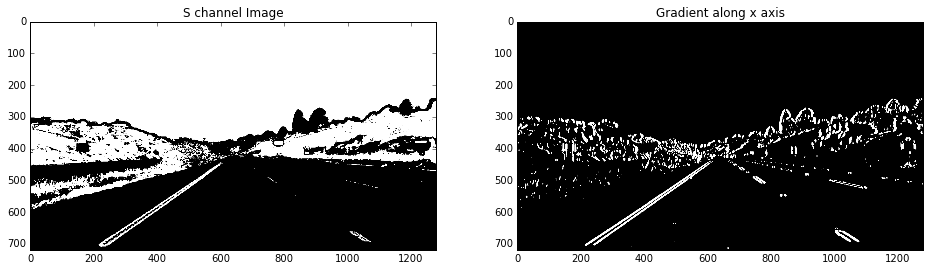

In [7]:
s_binary = hls_select(u_img,(60,250))
sxbinary = gradient_select(u_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9))
ax1.imshow(s_binary, cmap='gray')
ax1.set_title('S channel Image')
ax2.imshow(sxbinary, cmap='gray')
ax2.set_title('Gradient along x axis')

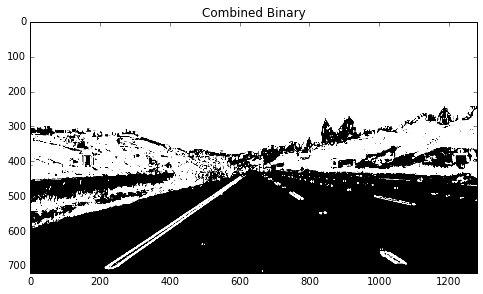

In [8]:
combined_binary = add_binary(s_binary, sxbinary)
f, ax1 = plt.subplots(1, 1, figsize=(8,9))
ax1.imshow(combined_binary, cmap='gray')
ax1.set_title('Combined Binary')

Now I need to change the perspective of the image so as to get a top down view of the road. This will show the lane lines parallel to each other.

For this I will create a source array `src` and a destination array `dst` and pass them to `cv2.getPerspectiveTransform()` to get the transformation matrix `M`

In [9]:
# src = np.float32([[180,660], [560,460], [720,460], [1130,660]])
# dst = np.float32([[200,719], [200,0], [979,0], [979,719]])
src = np.float32([[200,720], [600, 447], [679,447], [1100,720]])
dst = np.float32([[300, 720], [300, 0], [900, 0], [900, 720]])
M = cv2.getPerspectiveTransform(src, dst)
M_inv = cv2.getPerspectiveTransform(dst, src)
img_size = (u_img.shape[1], u_img.shape[0])
def warp(image, M):
    return cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)

Test `warp()` function

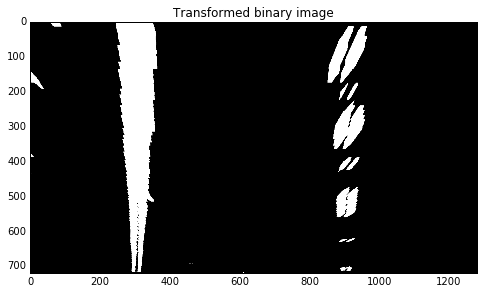

In [10]:
warped = warp(combined_binary, M)
f, ax1 = plt.subplots(1, 1, figsize=(8,9))
ax1.imshow(warped, cmap='gray')
ax1.set_title('Transformed binary image')

Now that I have got the top down view of the road as a binary image I need to find out which pixels make up the lane lines and which don't. To search for the lane lines I have created a function `sliding_window()` which scans the binary image to find both the right and left lane. 
Once I have found the lanes, in the next image frame I don't need to search the entire image again to get the lanes. Instead I can just search around the lane area I found in the previous frame. To do this I define another function `search_in_margin()`. In order for this to work I needed some data from the `sliding_window()`. 

To keep the data and the functionality together I defined a class called `Line()` and defined both the functions inside this class. Now the class holds the data for the lanes and also the functions which use this data.

To better understand what the functions are doing please go through the code. I have heavely commented the code to make it easier to understand.

In [29]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False       
        
        # polynomail cofficients for the current left and right lane
        self.left_fit = None
        self.right_fit = None
        
        # polynomial coefficients averaged over the last 10 iterations
        self.best_fit_left = None  
        self.best_fit_right = None 
        
        # store the cofficient for last 10 frames
        self.avg_left = np.array([])
        self.avg_right = np.array([])
        
        # x coordinates for the lane line
        self.left_fitx = None
        self.right_fitx = None
        
        # np array of y values 
        self.ploty = None
    
    def __perform_average(self):
        # append the values of cofficient for the current frame
        self.avg_left = np.append(self.avg_left, mylines.left_fit)
        self.avg_right = np.append(self.avg_right, mylines.right_fit)
        
        self.avg_left = np.reshape(self.avg_left,(-1,3))
        self.avg_right = np.reshape(self.avg_right,(-1,3))
        
        #select last 10 frames and calculate average
        self.avg_left = self.avg_left[-10:]
        self.avg_right = self.avg_right[-10:]
        self.best_fit_left = np.sum(self.avg_left,axis=0) / self.avg_left.shape[0]
        self.best_fit_right = np.sum(self.avg_right,axis=0) / self.avg_right.shape[0]
    
    """
    Find the lane lines in the image using sliding window technique
    This function accepts a binary image and returns the x,y coordiantes of the left & right lane
    if get_histogram flag is set then it also returns the histogram for the input binary image
    Note: get_histogram is used just for the purpose of visualization. 
    """
    def sliding_window(self, binary_warped, get_histogram = False):
        # clear previous values of class variables 
        self.__init__()
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
             
        # Fit a second order polynomial to each
        self.left_fit = np.polyfit(lefty, leftx, 2)
        self.right_fit = np.polyfit(righty, rightx, 2)

        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        self.ploty = ploty
        self.left_fitx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
        self.right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]
        
        # set the class variable
        self.detected = True
        if get_histogram == True:
            return self.left_fitx, self.right_fitx, ploty, histogram
        else:
            return self.left_fitx, self.right_fitx, ploty, None
    
    """
    This function accepts a binary image and performs a search for lane line pixels in an area
    around the lane lines detected in the previous frame. This function uses the (x,y) coordinates
    of the lane lines detected in the previous frame. 
    """
    def search_in_margin(self, binary_warped, out_img):
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        margin = 100
        self.__perform_average()
        left_lane_inds = ((nonzerox > (self.best_fit_left[0]*(nonzeroy**2) + self.best_fit_left[1]*nonzeroy + 
        self.best_fit_left[2] - margin)) & (nonzerox < (self.best_fit_left[0]*(nonzeroy**2) + 
        self.best_fit_left[1]*nonzeroy + self.best_fit_left[2] + margin))) 

        right_lane_inds = ((nonzerox > (self.best_fit_right[0]*(nonzeroy**2) + self.best_fit_right[1]*nonzeroy + 
        self.best_fit_right[2] - margin)) & (nonzerox < (self.best_fit_right[0]*(nonzeroy**2) + 
        self.best_fit_right[1]*nonzeroy + self.best_fit_right[2] + margin)))  
        
        if len(left_lane_inds) < 10000 or len(right_lane_inds) < 10000:
            self.detected = False
            left_fitx, right_fitx, ploty = self.sliding_window(binary_warped)
            return left_fitx, right_fitx, ploty
        
        else:
            # extract left and right line pixel positions
            leftx = nonzerox[left_lane_inds]
            lefty = nonzeroy[left_lane_inds] 
            rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds]
            # Fit a second order polynomial to each
            self.left_fit = np.polyfit(lefty, leftx, 2)
            self.right_fit = np.polyfit(righty, rightx, 2)
            
            self.__perform_average()
            
            # Generate x and y values for plotting
            ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
            self.ploty = ploty
            self.left_fitx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
            self.right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]
            
            return self.left_fitx, self.right_fitx, ploty
    
    """
    This function calculates the radius of curvature of the lanes in meters.
    It returns the in a string format.
    """
    def calc_roc(self):
        y_eval = np.max(self.ploty)
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(self.ploty*ym_per_pix, self.left_fitx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(self.ploty*ym_per_pix, self.right_fitx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        roc = int((left_curverad + right_curverad) / 2)
        text = "Radius of Curvature: " + str(roc) + "(m)"
        return text
    
    """
    This function calculates the offset of the car from the center of the lane.
    The offset value is in meters. The function returns the offset as a string.
    """
    def calc_offset(self):
        # bottom of right lane line
        x2 = self.left_fitx[-1]
        # bottom of left lane line
        x1 = self.right_fitx[-1]
        # calculate the center point of the lane
        lane_center = (x2-x1)/2 + x1
        # set the center of the car (assuming camera is mounter at the center of the car)
        car_center = 639.5    # image width/2
        # calculate the offset
        offset = car_center - lane_center
        offset = offset*3.7/700    # convet the value from px to m
        offset = round(offset,2)
        if offset >= 0:
            text = "vehicle is " + str(abs(offset)) + "(m) right of center"
        else:
            text = "vehicle is " + str(abs(offset)) + "(m) left of center"
        return text

Now that i have my class and associated functions/methods ready, I will create another function called `find_lines()`. This function will call the appropriate method of the class depending on which frame is getting processed and whether the detection is approprate or not. 

In [30]:
# create an object of Line class
mylines = Line()

"""
This function accepts a binary image as an input.
It calls the appropriate method of the Line class to find the lane lines
and returns an image with lane area highlighted in green.
"""
def find_lines(binary_warped, get_hist=False):
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    if mylines.detected == False:
        left_fitx, right_fitx, ploty, hist = mylines.sliding_window(binary_warped, get_hist)
    
    else:
        left_fitx, right_fitx, ploty = mylines.search_in_margin(binary_warped, out_img)
        hist = None
            
    window_img = np.zeros_like(out_img)

    # recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    
    lane_pts = np.hstack((left_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([lane_pts]), (0,255, 0))
    
    return window_img, hist

In [31]:
"""
Print the radius of curvature and offset from center text
over the image.
"""
def print_roc_offset(img):
    roc_text = mylines.calc_roc()
    offset_text = mylines.calc_offset()
    cv2.putText(img=img, 
                text=roc_text, 
                org=(50,70), 
                fontFace=cv2.FONT_HERSHEY_COMPLEX_SMALL, 
                fontScale=2, 
                color=(255,255,255), 
                thickness=2)
    cv2.putText(img=img, 
                text=offset_text, 
                org=(50,140), 
                fontFace=cv2.FONT_HERSHEY_COMPLEX_SMALL, 
                fontScale=2, 
                color=(255,255,255), 
                thickness=2)
    return img

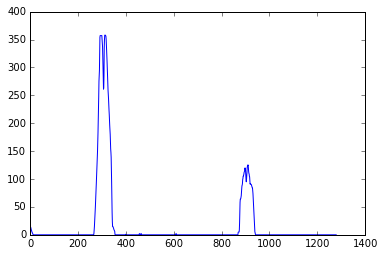

In [32]:
marked_binary, hist = find_lines(warped, True)
unwarped = warp(marked_binary, M_inv)
final_img = cv2.addWeighted(u_img, 1, unwarped, 0.3, 0)
final_img = print_roc_offset(final_img)
plt.plot(hist)

As seen in the histogram the detection of pixels in the binary image for the left and right lane is quite good.

Now let's mark the lane area onto the original image.

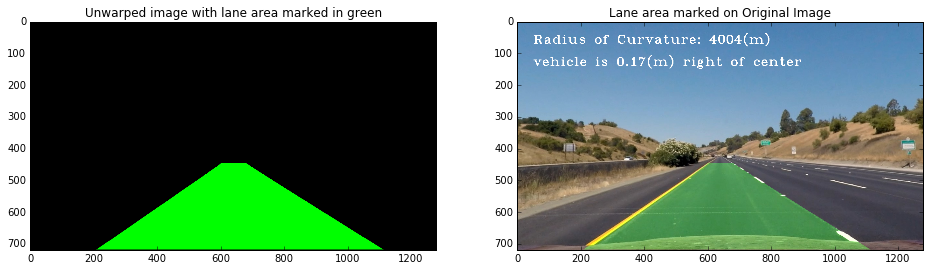

In [33]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9))
ax1.imshow(unwarped)
ax1.set_title('Unwarped image with lane area marked in green')
ax2.imshow(final_img)
ax2.set_title('Lane area marked on Original Image')

The result is looking good. Now its time to use all the functions together to build the video processing pipeline.

#### Stiching it all together
After looking at the above result and testing the code on various different images I am ready to build up my pipeline to process the video.

In [34]:
def pipeline(image):
    img = undistort(image, mtx, dist)
    b1 = hls_select(img)
    b2 = gradient_select(img)
    cb = add_binary(b1, b2)
    warped = warp(cb, M)
    marked_binary, hist = find_lines(warped)
    unwarped = warp(marked_binary, M_inv)
    final_img = cv2.addWeighted(img, 1, unwarped, 0.3, 0)
    final_img = print_roc_offset(final_img)
    return final_img

Just to be sure that everying works the way it should,  I again test my pipeline on a image and see the result.

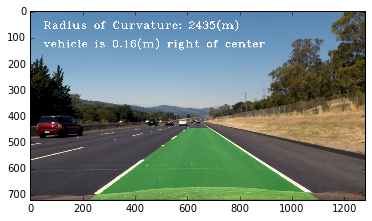

In [35]:
img = mpimg.imread('./test_images/straight_lines2.jpg')
mylines = Line()
final = pipeline(img)
plt.imshow(final)

Okay. that looks good. Now let's test it out on video.

In [36]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os

# create a folder to store the output video
if(not(os.path.exists("./test_videos_output"))):
    os.mkdir("test_videos_output/")
mylines = Line()    
video_output = 'test_videos_output/output_video.mp4'

clip1 = VideoFileClip("./project_video.mp4")
processed_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time processed_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/output_video.mp4
[MoviePy] Writing video test_videos_output/output_video.mp4


100%|█████████████████████████████████████▉| 1260/1261 [06:20<00:00,  3.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/output_video.mp4 

Wall time: 6min 23s


In [37]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))